# Hair style segmentation (part 1 of hairstyle swap)

## Set up Google Colab

In [0]:
%ls

In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [0]:
cd bdrive/My\ Drive/app/Hair-segmentation/

In [0]:
from PIL import Image
Image.open(open("images/works.jpg", "rb"))

In [0]:
!pip install torch torchvision

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.misc
import scipy.ndimage
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models, transforms, utils
from torchvision.models.vgg import VGG

from PIL import Image
import warnings

warnings.filterwarnings("ignore")

## Data 

### Load dataset

In [0]:
"""
class PartLFW(Dataset):
  
  def __init__(self, phase, img_file="data/LFW-keras/images-192.npy", lbl_file="data/LFW-keras/masks-192.npy"):
    self.phase = phase
    self.images = np.load(img_file)
    self.masks = np.expand_dims(np.load(lbl_file)[:, :, :, 0], axis=4)
         
  def __getitem__(self, index):
    image = self.images[index]
    mask = self.masks[index]
    
    label = np.zeros((192, 192, 3), dtype=np.uint8)
    label[:, :, 0] = mask[:, :, 0]
        
    if self.phase == "train":
      
      x, y = 192, 192
      """
      # RandomZoom
      if random.random() < 0.2:
        cropin = 120      
        startx = x//2-(cropin//2)
        starty = y//2-(cropin//2)
        image = image[starty:starty+cropin, startx:startx+cropin]
        label = label[starty:starty+cropin, startx:startx+cropin]

        image = scipy.misc.imresize(image, (x, y))
        label = scipy.misc.imresize(label, (x, y))  """
      
      #RandomHorizontalFlip
      if random.random() < 0.5:
        image = np.fliplr(image)
        label = np.fliplr(label)
        
      
      # RandomRotate
      if random.random() < 0.2:
        angle = random.randint(0, 20)
        image = scipy.ndimage.rotate(image, angle)
        label = scipy.ndimage.rotate(label, angle)
        
        image = scipy.misc.imresize(image, (x, y))
        label = scipy.misc.imresize(label, (x, y))
        
   
    # Change RGB for class id 
    h, w, _ =  label.shape
    label_enc = np.zeros((h, w)).astype(np.uint8)
    for i in range (h):
      for j in range(w):
        color = tuple(label[i, j])
        try: 
          if 255 in color:
            label_enc[i, j] = 1
        except:
          return None
          print ("Error")
        
    # Normalization 
    mean = [29.24429131, 29.24429131, 29.24429131]
    std = [69.8833313, 63.37436676, 61.38568878]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]
          
    # ToTensor
    image = torch.from_numpy(image.copy()).float()
    label = torch.from_numpy(label_enc.copy()).long()
       
    # One-hot encoding 
    h, w = label.size()
    n_classes = 1
    
    target = torch.zeros(n_classes, h, w) 
    for c in range(n_classes):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label}
    
  def __len__(self):
    return len(self.images)
  
  
dataset = PartLFW(phase="train")
batch_size = 5
val_split = 0.2
shuffle=True
seed = 1

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))

split = int(np.floor(val_split * dataset_size))

if shuffle :
    np.random.seed(seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
  
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validloader = torch.utils.data.DataLoader(PartLFW(phase="valid"), batch_size=1,
                                                sampler=valid_sampler)"""

In [0]:
class PartLFW(Dataset):
  
  def __init__(self, phase, img_file="data/LFW-keras/images-192.npy", lbl_file="data/LFW-keras/masks-192.npy"):
    self.phase = phase
    self.images = np.load(img_file)
    self.labels = np.load(lbl_file)
    
  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]
    
    if self.phase == 'train':
      # data augmentation 
      pass
    
    # Normalize 
    mean = [[[29.24429131, 29.24429131, 29.24429131]]]
    std = [[[69.8833313, 63.37436676, 61.38568878]]]
    
    image = (image.copy().astype(float) - np.array(mean)) / (np.array(std) + 1e-7)
    
    # Color to Class - This is so bad, needs to be done when create the npy files
    h, w, _ = label.shape
    new_label = np.zeros((h ,w))
    for i in range(h):
      for j in range(w):
        if label[i, j, 2] == 255: new_label[i, j] = 2
        elif label[i, j, 1] == 255: new_label[i, j] = 1
        else: new_label[i, j] = 0
    
    # ToTensor
    image = torch.from_numpy(image.copy()).float()
    label = torch.from_numpy(new_label.copy()).long()
    
    # One-hot Encoding 
    h, w = label.size()
    n_classes = 3
    
    target = torch.zeros(n_classes, h, w) 
    for c in range(n_classes):
      target[c][label == c] = 1
    
    return {'x': image, 'y':target, 'l':label}
  
  def __len__(self):
    return len(self.images)
  

data = PartLFW(phase="train")
batch_size = 16
shuffle = True 
val_split = 0.2
seed = 1

# Create indices for training and validation
idx = list(range(len(data)))
split = int(np.floor(val_split * len(data)))

if shuffle:
  np.random.seed(seed)
  np.random.shuffle(idx)
  
train_ids, valid_ids = idx[split:], idx[:split]
print("train: ", len(train_ids), "validation: ", len(valid_ids))

# Build data loaders 
train_sampler = SubsetRandomSampler(train_ids)
valid_sampler = SubsetRandomSampler(valid_ids)

trainloader = torch.utils.data.DataLoader(PartLFW(phase="train"), batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(PartLFW(phase="valid"), batch_size=1, sampler=valid_sampler)

train:  2342 validation:  585


In [0]:
data = next(iter(trainloader))
image = data['x']
target = data['y']
label = data['l']

print(image.shape, target.shape, label.shape)

torch.Size([16, 192, 192, 3]) torch.Size([16, 3, 192, 192]) torch.Size([16, 192, 192])


In [0]:
plt.imshow(image[16])

In [0]:
def desnormalize(image, mean=None, std=None):
  if mean is None:
    mean = [[[29.24429131, 29.24429131, 29.24429131]]]
  if std is None:
    std = [[[69.8833313, 63.37436676, 61.38568878]]]
  #x = (image - np.array(mean)) / (np.array(std) + 1e-7)
  x = (image + np.array(mean)) * (np.array(std) - 1e-7)
  return x

img = desnormalize(image[7].numpy)
plt.imshow(img)


In [0]:
from glob import glob 
import re
import cv2

class PartLFW(Dataset):
  def __init__(self, images, labels, transform, label_transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.label_transform = transform
    if label_transform is not None:
      self.label_transform = label_transform
      
  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    label = cv2.imread(self.labels[index])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
    
    seed = random.randint(0, 2**32)
    
    # Transform images 
    random.seed(seed)
    image = Image.fromarray(image)
    image = self.transform(image)
    
    # Transform labels
    random.seed(seed)
    label = Image.fromarray(label)
    label = self.label_transform(label)
    
    return image, label
  
  def __len__(self):
    return len(self.images)
    
    
    
train_transforms = transforms.Compose([transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                                       transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
                                       transforms.RandomAffine(10.),
                                       transforms.RandomRotation(13.),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),])

valid_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),])


labels = sorted(glob('data/raw/masks/*.ppm'))
images = []

for label in labels:
  image = re.sub('^data/raw/masks', 'data/raw/images', label)
  image = re.sub('\.ppm$', '.jpg', image)
  images.append(image)


trainloader = torch.utils.data.DataLoader(PartLFW(images, labels, train_transforms), batch_size=8, shuffle=True, pin_memory=True)
validloader = torch.utils.data.DataLoader(PartLFW(images, labels, valid_transforms), batch_size=1, pin_memory=True)
      

### Visualize dataset sample

In [0]:
image, label = next(iter(trainloader))

In [34]:
print(image.shape, label.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])


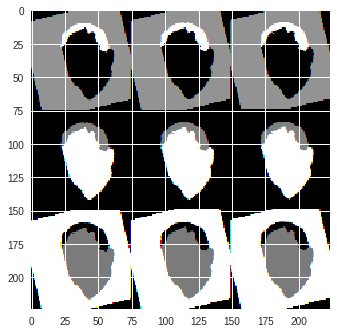

In [37]:
plt.imshow(label[4].reshape(224, 224, 3))

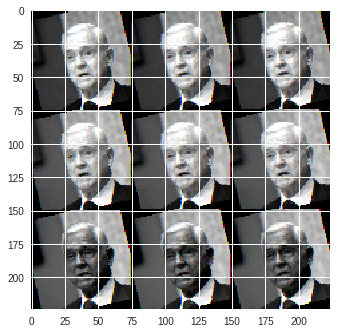

In [39]:
plt.imshow(image[4].reshape(224, 224, 3))

## Model

### Encoder 

In [0]:
class VGG16(VGG):
  
  def __init__(self, pretrained=True, requires_grad=True, remove_fc=True, padding=True, show_params=False):
    super().__init__(self.make_layers())
        
    if pretrained:
      exec("self.load_state_dict(models.vgg16(pretrained=True).state_dict())")
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if padding:
      self.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=100)
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))
    output = {}
    for idx in range(len(ranges)):
      for layer in range(ranges[idx][0], ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, batch_norm=False):
    cfg = [64, 64, 'M',
           128, 128, 'M', 
           256, 256, 256, 'M', 
           512, 512, 512, 'M', 
           512, 512, 512, 'M']
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

In [0]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    
    # fc6 of VGG16
    self.fc6 = nn.Conv2d(512, 512, 7)
    self.relu6 = nn.LeakyReLU(inplace=True) #nn.ReLU(inplace=True)
    self.drop6 = nn.Dropout2d()
    
    # fc7 of VGG16 
    self.fc7 = nn.Conv2d(512, 4096, 1)
    self.relu7 = nn.LeakyReLU(inplace=True) #nn.ReLU(inplace=True)
    self.drop7 = nn.Dropout2d()
    
    # Convolutional score layer 
    self.score_fr = nn.Conv2d(4096, n_classes, 1)
    
    # Upsampling (Deconvolutions)
    self.score_pool3 = nn.Conv2d(256, n_classes, 1)
    self.score_pool4 = nn.Conv2d(512, n_classes, 1)
    
    self.upscore2 = nn.ConvTranspose2d(n_classes, n_classes,  4, stride=2, bias=False)
    self.upscore8 = nn.ConvTranspose2d(n_classes, n_classes, 16, stride=8, bias=False)
    
    self.upscore_pool4 = nn.ConvTranspose2d(n_classes, n_classes, 4, stride=2, bias=False)
  
  def forward(self, x):
    img = x
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu6(self.fc6(pool_5))
    x = self.drop6(x)
    
    x = self.relu7(self.fc7(x))
    x = self.drop7(x)
    
    x = self.score_fr(x)
    x = self.upscore2(x)
    upscore2 = x
        
    x = self.score_pool4(pool_4)
    x = x[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
    score_pool4 = x
    
    x = upscore2 + score_pool4
    x = self.upscore_pool4(x)
    upscore_pool4 = x
    
    x = self.score_pool3(pool_3)
    x = x[:, :, 9:9 + upscore_pool4.size()[2], 9:9 + upscore_pool4.size()[3]]
    score_pool3 = x
    
    x = upscore_pool4 + score_pool3
    
    x = self.upscore8(x)
    
    x = x[:, :, 31:31 + img.size()[2], 31:31 + img.size()[3]].contiguous()
    
    return x

### Test shapes

In [46]:
batch, n_classes, height, width = 1, 3, 500, 500

model = FCN8s(VGG16(), n_classes)
model.to(device)

input_img = torch.rand(batch, n_classes, height, width)
out_pred = model(input_img.to(device))

assert out_pred.size() == torch.Size([batch, n_classes, height, width])
print("correct shapes")


correct shapes


## Train FCN

### Evaluation functions

In [0]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, validloader):
  total_ious = []
  pixel_accs = []
  for i, batch in enumerate(validloader):
    inputs = batch[0].to(device)
    output = model(inputs)
    output = output.data.cpu().numpy()
        
    N, _, h, w = output.shape 
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
    target = batch[1].cpu().numpy().reshape(N, h, w)
    
    for y_hat, y in zip(pred, target):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  return pixel_acc, mean_iou

In [0]:
def dice_loss(pred, target, smooth=1e-5):

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1-((2. * intersection + smooth) / (A_sum + B_sum + smooth))

### Parameters

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define model
n_classes = 3
model = FCN8s(VGG16(), n_classes)
model.to(device)

#weights = [[[1./80]], [[1./15]], [[1./5]]]
#class_weights = torch.FloatTensor(weights).to(device)

#criterion = nn.BCEWithLogitsLoss(weight=class_weights)
#optimizer = optim.SGD(model.parameters(), lr=1e-12, momentum=0.99, weight_decay=0.005)

optimizer = optim.Adam(model.parameters(), lr=1e-4)


#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)




epochs = 100
print_every = 70

### Accuracy before training

In [0]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, validloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

### Train

In [0]:
best = 0
for epoch in range(epochs):
  for i, batch in enumerate(trainloader):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = dice_loss(outputs, labels)    
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        paccuracy, meaniou = 0, 0 #validation(model, validloader)
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training loss: {:.5f}.. ".format(loss.item()),
              "Pixel accuracy.. {:.5f}".format(paccuracy),
              "Mean IU.. {:.5f}".format(meaniou))
      if best < paccuracy:
        torch.save(model.state_dict(), "./fcn-model-bestacc33.pth")
        best = paccuracy
      model.train()



In [0]:
print(l.long().shape)
print(y.long())

In [0]:
print(l.long()[:,0].shape)
print(l.long()[:])

In [0]:
torch.save(model.state_dict(), "./fcn-badmodel90.pth")

In [0]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, testloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.9017856699029126  Mean IoU:  0.6518089853144712


## Inference

In [0]:
state_dict = torch.load('./fcn-model-bestacc.pth')
model.load_state_dict(state_dict)

In [0]:
inference_transforms = transforms.Compose([ #transforms.Resize((192, 192)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([29.24429131, 29.24429131, 29.24429131],[69.8833313, 63.37436676, 61.38568878])])

def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

def load_image(image):
  if isinstance(image, str):
    image = Image.open(image).convert('RGB')
  else:
    image = Image.fromarray(image).convert('RGB')
  image = inference_transforms(image)
  image = torch.tensor(image, requires_grad=False)
  image = image.unsqueeze(0)
  return image

def get_predicted_image(original, prediction, labels=None):
  _, h, w = prediction.shape
  
  output = np.zeros((h, w, 3), dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      index = prediction[0][i][j] + 1
      try:
        if labels is not None:
          if index in labels:
            color = gt_labels.get(index)[1]
            output[i, j, 0] = color[0]
            output[i, j, 1] = color[1]
            output[i, j, 2] = color[2]
          else:
            output[i, j, 0] = original[i, j, 0]
            output[i, j, 1] = original[i, j, 1]
            output[i, j, 2] = original[i, j, 2]
        else:
          color = gt_labels.get(index)[1]
          output[i, j, 0] = color[0]
          output[i, j, 1] = color[1]
          output[i, j, 2] = color[2]
      except:
        print("Upss, didn't work")
        break
  return output

def get_image_labels(testimage, n_classes):
  model.to(device)
  model.eval()
  image = load_image(testimage)
  prediction = model(image.to(device))
  prediction = prediction.data.cpu().numpy()
  N, _, h, w = prediction.shape
  prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
  return prediction


def paint(predicted):
  h, w = 500, 500
  output = np.zeros((500, 500, 3), dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      if predicted[0][i][j] == 0:
        output[i, j, 2] = 255
      elif predicted[0][i][j] == 1:
        output[i, j, 1] = 255
      elif predicted[0][i][j] == 2:
        output[i, j, 0] = 255
  return output

def paint_no_tensor(predicted):
  output = np.zeros((500, 500, 3), dtype=np.uint8)
  for i in range(500):
    for j in range(500):
      if predicted[0][i][j] == 0:
        output[i, j, 2] = 255
      elif predicted[0][i][j] == 1:
        output[i, j, 1] = 255
      elif predicted[0][i][j] == 2:
        output[i, j, 0] = 255
  return output

In [0]:
"""
name = "Alex_King_0001"

inp_image = "data/LFW/images/" + name + ".jpg"
tru_image = "data/LFW/labels_ppm/" + name + ".ppm"

original = scipy.misc.imread(inp_image)
truth = scipy.misc.imread(tru_image)
predicted = get_image_labels(inp_image, 1)

"""
data = pd.read_csv("data/LFW/training.csv")

image, label = data.iloc[7, 0], data.iloc[7, 1]
image = scipy.misc.imread(image, mode='RGB')
label = np.load(label) 

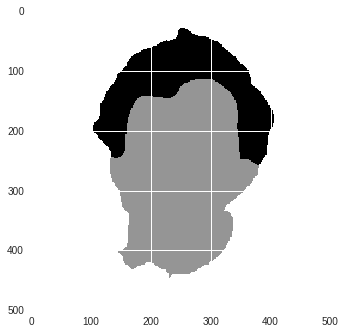

In [0]:
plt.imshow(label)

In [0]:
predicted = get_image_labels(image, 3)
print(predicted.shape)

(1, 500, 500)


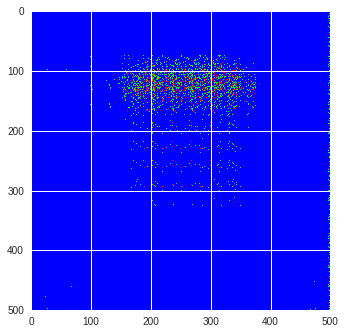

In [0]:
plt.imshow(paint(predicted))

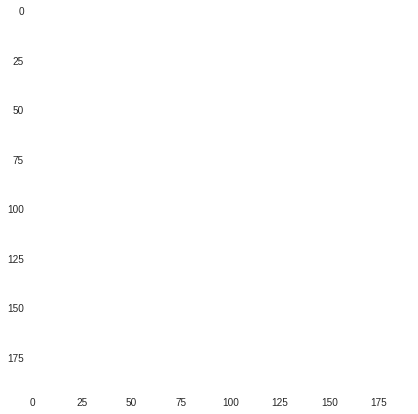

In [0]:
plt.imshow(predicted[0])

In [0]:
model.to(device)
model.eval()
image = load_image(inp_image)

prediction = model(image.to(device))
prediction = prediction.data.cpu().numpy()
N, _, h, w = prediction.shape

print(prediction.shape)
print(torch.sigmoid(prediction))
#prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)

torch.Size([1, 1, 192, 192])
tensor([[[[0.9933, 0.9897, 0.9915,  ..., 0.9968, 0.9965, 0.9965],
          [0.9942, 0.9979, 0.9956,  ..., 0.9982, 0.9975, 0.9981],
          [0.9964, 0.9961, 0.9952,  ..., 0.9979, 0.9941, 0.9789],
          ...,
          [0.9971, 0.9977, 0.9984,  ..., 0.9955, 0.9972, 0.9886],
          [0.9964, 0.9967, 0.9962,  ..., 0.9927, 0.9995, 0.9948],
          [0.9972, 0.9976, 0.9967,  ..., 0.9943, 0.9959, 0.9970]]]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


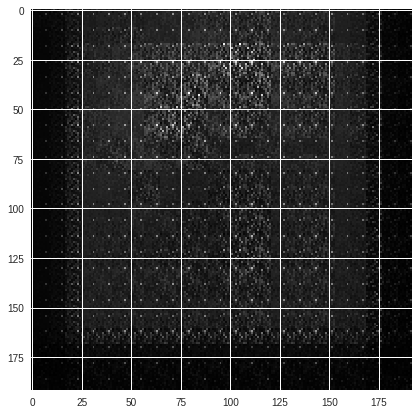

In [0]:
plt.imshow(torch.sigmoid(prediction)[0][0].cpu().detach().numpy())